In [11]:
import numpy as np 
import pandas as pd
from sortedcontainers import SortedList
from datetime import datetime

In [12]:
url = 'https://raw.githubusercontent.com/sitsawek/dataset/main/healthcare/healthcare_dataset.csv'
data = pd.read_csv(url)

In [13]:
data.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


In [29]:
# Clean colums
all_columns = data.columns
new_columns = []
for i in all_columns:
    new_col = i.lower().replace(' ', '_')
    new_columns.append(new_col)
data.columns = new_columns

In [30]:
data.head()

,name,age,gender,blood_type,medical_condition,date_of_admission,doctor,hospital,insurance_provider,billing_amount,room_number,admission_type,discharge_date,medication,test_results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


In [31]:
data['test_results'].unique()

array(['Inconclusive', 'Normal', 'Abnormal'], dtype=object)

In [32]:
# Create function to encode target label
def encode_test_results(data):
    if data == 'Normal':
        return 0
    if data == 'Abnormal':
        return 1
    if data == 'Inconclusive':
        return 2

In [136]:
# Transform columns
data['encode_test_results'] = data['test_results'].apply(lambda x: encode_test_results(x))

In [311]:
list(data.select_dtypes(include='number').columns)

['age', 'billing_amount', 'room_number', 'encode_test_results']

In [475]:
len(data.select_dtypes(include='number').columns)

4

In [482]:
def get_healthcare_data(df, limit = None):
    # To get only numeric columns for calculate distance for knn
    df = df.select_dtypes(include='number')
    data = df.values
    np.random.shuffle(data)
    X = data[:, :-1]
    Y = data[:, -1]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y
    

In [192]:
def get_xor():
    X = np.zeros((200, 2)) # generate 2D arrays (200 rows, 2 columns)
    X[:50] = np.random.random((50, 2)) / 2 + 0.5 # Assign values for index between 0 to 49.
    X[50:100] = np.random.random((50, 2)) / 2
    X[100:150] = np.random.random((50, 2)) / 2 + np.array([[0, 0.5]])
    X[150:] = np.random.random((50, 2)) / 2 + np.array([[0.5, 0]])
    Y = np.array([0]*100 + [1]*100) # Create data 0 at 100 points and 1 at 100 points, total 200 points
    return X, Y

In [267]:
def get_donut():
    N = 200
    R_inner = 5
    R_outer = 10
    # distance from original is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer 
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T 

    X = np.concatenate([X_inner, X_outer])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    return X, Y
    
    

In [486]:
# Create class for KNN model
class KNN(object):
    def __init__(self, k):
        self.k = k 

    def fit(self, X, y):
        self.X = X
        self.y = y 
    
    def predict(self, X):
        y = np.zeros(len(X))
        # enumerate to return index and records 
        for i, x in enumerate(X):
            # create sorted list for collect and sort order
            sl = SortedList() # use SortedList() because this default ascending order, in knn we need to find which data point is closely.
            # enumerate to compare each records to each records
            # to check whether which the most nearest data point and add to list 
            for j, xt in enumerate(self.X):
                diff = x - xt # find distance here
                d = diff.dot(diff) # find square distance by self diff dot ((x-y)**2)
                if len(sl) < self.k: # check in sorted list are meet k we set? if not add until meet k
                    sl.add((d, self.y[j])) # Add tuple of values distance and index
                else:
                    if d < sl[-1][0]: # check if last values in list vs. last distance
                        del sl[-1] # if last distance more closely then delete last tuple in list
                        sl.add((d, self.y[j])) # and add new distance
            # print(sl) # For reconcile data is correct in votes we add in next line.
            votes = {}
            for _, v in sl:
                votes[v] = votes.get(v, 0) + 1 # add each class to dict prepare ready for votes
            # print(votes) # Show count of each vote
            max_votes = 0 # set initial by 0 for check is there have some count in each class?
            max_votes_class = -1 # set initial magic number for no count class.
            for v, count in votes.items():
                if count > max_votes: # if there have some count add as max votes for next iteration.
                    max_votes = count 
                    max_votes_class = v 
            # Finaly we know predict class for record i, then assign max votes class to y
            y[i] = max_votes_class 
        return y
    
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

# Check wheter import or directly run
# if __name__ == '__main__':
X, Y = get_healthcare_data(data, 2000)
Ntrain = 1000
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]
# knn = KNN(3) # For test & reconcile function
# knn.fit(Xtrain, Ytrain) # For test & reconcile function
# knn.score(Xtrain, Ytrain) # For test & reconcile function
    # Test difference values of k
for k in (1,2,3,4,5):
    knn = KNN(k)
    t0 = datetime.now()
    knn.fit(Xtrain, Ytrain)
    print('Training time:', (datetime.now() - t0))

    t0 = datetime.now()
    print('Training accuracy:', knn.score(Xtrain, Ytrain))
    print('Time to compute train accuracy:', (datetime.now() - t0), 'Training size:', len(Ytrain))

    t0 = datetime.now()
    print('Test accuracy:', knn.score(Xtest, Ytest))
    print('Time to compute test accuracy:', (datetime.now() - t0), 'Test size:', len(Ytest))


    

Training time: 0:00:00.000010
Training accuracy: 1.0
Time to compute train accuracy: 0:00:02.735036 Training size: 1000
Test accuracy: 0.358
Time to compute test accuracy: 0:00:02.540927 Test size: 1000
Training time: 0:00:00.000005
Training accuracy: 1.0
Time to compute train accuracy: 0:00:02.527324 Training size: 1000
Test accuracy: 0.358
Time to compute test accuracy: 0:00:02.513823 Test size: 1000
Training time: 0:00:00.000017
Training accuracy: 0.758
Time to compute train accuracy: 0:00:02.578601 Training size: 1000
Test accuracy: 0.349
Time to compute test accuracy: 0:00:02.691331 Test size: 1000
Training time: 0:00:00.000004
Training accuracy: 0.728
Time to compute train accuracy: 0:00:02.708084 Training size: 1000
Test accuracy: 0.328
Time to compute test accuracy: 0:00:02.596835 Test size: 1000
Training time: 0:00:00.000003
Training accuracy: 0.705
Time to compute train accuracy: 0:00:02.649042 Training size: 1000
Test accuracy: 0.328
Time to compute test accuracy: 0:00:02.55

In [416]:
# Show how knn can fail
import matplotlib.pyplot as plt

In [427]:
def get_data():
    width = 8
    height = 8
    N = width * height 
    X = np.zeros((N, 2))
    Y = np.zeros(N)
    n = 0
    start_t = 0
    for i in range(width): # Loop through rows
        t = start_t
        for j in range(height): # Loop through columns
            X[n] = [i, j]
            Y[n] = t
            n += 1
            t = (t + 1) % 2
        start_t = (start_t + 1) % 2
    return X, Y

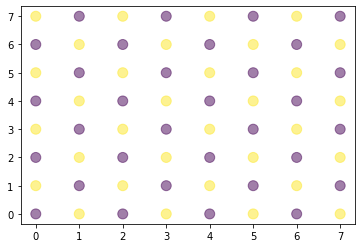

In [488]:
X, Y = get_data() # test althernate data
plt.scatter(X[:,0], X[:, 1], s=100, c=Y, alpha=0.5)
plt.show()

In [489]:
model = KNN(3)
model.fit(X, Y)
model.score(X, Y)

0.0